step     1 | g(a)=1.062390 | yTa=-2.082e-17 | min(a)=2.000e-02 | max(a)=2.000e-02
step  1000 | g(a)=8.493692 | yTa=-7.889e-10 | min(a)=0.000e+00 | max(a)=3.776e+00
step  2000 | g(a)=9.007846 | yTa=-9.126e-10 | min(a)=0.000e+00 | max(a)=5.994e+00
step  3000 | g(a)=9.331737 | yTa=-1.163e-09 | min(a)=0.000e+00 | max(a)=8.012e+00
step  4000 | g(a)=9.497792 | yTa=1.617e-09 | min(a)=0.000e+00 | max(a)=9.327e+00
step  5000 | g(a)=9.512141 | yTa=1.614e-09 | min(a)=0.000e+00 | max(a)=9.463e+00
step  6000 | g(a)=9.520526 | yTa=1.606e-09 | min(a)=0.000e+00 | max(a)=9.483e+00
step  7000 | g(a)=9.526101 | yTa=1.629e-09 | min(a)=0.000e+00 | max(a)=9.493e+00
step  8000 | g(a)=9.529812 | yTa=1.564e-09 | min(a)=0.000e+00 | max(a)=9.501e+00
step  9000 | g(a)=9.532281 | yTa=1.577e-09 | min(a)=0.000e+00 | max(a)=9.508e+00
step 10000 | g(a)=9.533924 | yTa=1.588e-09 | min(a)=0.000e+00 | max(a)=9.513e+00
step 11000 | g(a)=9.535017 | yTa=1.596e-09 | min(a)=0.000e+00 | max(a)=9.518e+00
step 12000 | g(a)=9.5357

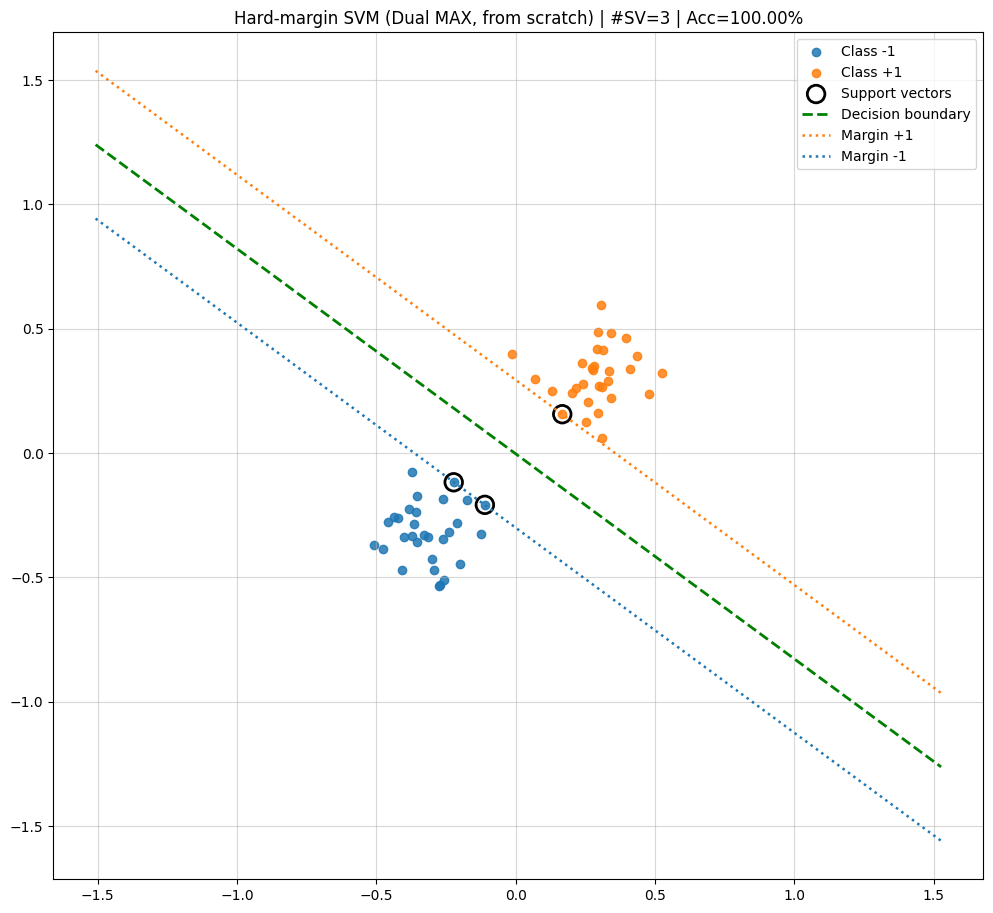

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_separable_data(n=130, seed=42, gap=0.4, noise=0.12):
    np.random.seed(seed)
    X_neg = np.random.randn(n, 2) * noise + np.array([-gap, -gap])
    X_pos = np.random.randn(n, 2) * noise + np.array([gap,  gap])
    X = np.vstack([X_neg, X_pos]).astype(float)
    y = np.hstack([-np.ones(n), np.ones(n)]).astype(float)
    return X, y, X_neg, X_pos



def build_Q_linear(X, y):
    K = X @ X.T                  
    yy = np.outer(y, y)           
    Q = yy * K                    
    Q =  0.5 * (Q + Q.T)         
    return Q


def proj_nonneg(a):
    return np.maximum(a, 0.0)


def proj_y_eq_0(a, y):
    denom = np.dot(y, y)
    if denom < 1e-15:
        return a
    return a - y * (np.dot(y, a) / denom)


def proj_intersection_dykstra(a0, y, iters=200, tol=1e-10):
    a = a0.copy()
    p = np.zeros_like(a)
    q = np.zeros_like(a)

    for _ in range(iters):
        a_old = a

        x = proj_nonneg(a + p)
        p = a + p - x

        a = proj_y_eq_0(x + q, y)
        q = x + q - a

        if np.linalg.norm(a - a_old) < tol:
            break
    return a



def solve_dual_max_projected(Q, y, lr=0.01, steps=8000, proj_iters=200, verbose=True):
    n = len(y)
    a = np.zeros(n, dtype=float)
    one = np.ones(n, dtype=float)

    def g(a):
        return one @ a - 0.5 * a @ (Q @ a)

    for t in range(1, steps + 1):
        grad_g = one - (Q @ a)              
        a = a + lr * grad_g                

        a = proj_intersection_dykstra(a, y, iters=proj_iters)
        a[a < 0] = 0.0

        if verbose and (t % 1000 == 0 or t == 1):
            print(
                f"step {t:5d} | g(a)={g(a):.6f} | yTa={np.dot(y,a):.3e} "
                f"| min(a)={a.min():.3e} | max(a)={a.max():.3e}"
            )

    return a



def recover_w_b(X, y, alphas, sv_tol=1e-6):
    w = (alphas * y) @ X
    sv_idx = np.where(alphas > sv_tol)[0]
    if len(sv_idx) == 0:
        raise RuntimeError(
            "No support vectors found. Try lr/steps or ensure separable data.")

    b_vals = y[sv_idx] - (X[sv_idx] @ w)
    b = float(np.mean(b_vals))
    return w, b, sv_idx


def check_hard_margin_constraints(X, y, w, b):
    vals = y * (X @ w + b)
    return float(vals.min()), float(vals.max()), vals


def plot_svm(X_neg, X_pos, X, y, w, b, sv_idx, title="Hard-margin SVM (Dual MAX, from scratch)"):
    plt.figure(figsize=(12, 11))
    plt.scatter(X_neg[:, 0], X_neg[:, 1], alpha=0.85, label="Class -1")
    plt.scatter(X_pos[:, 0], X_pos[:, 1], alpha=0.85, label="Class +1")

    sv = X[sv_idx]
    plt.scatter(sv[:, 0], sv[:, 1], s=160, facecolors="none",
                edgecolors="k", linewidths=2.0, label="Support vectors")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xx = np.linspace(x_min, x_max, 300)

    if abs(w[1]) < 1e-12:
        plt.axvline(-b / (w[0] + 1e-12), linestyle="--",
                    linewidth=2, color="green", label="Decision boundary")
        plt.axvline(-(b - 1) / (w[0] + 1e-12), linestyle=":",
                    linewidth=1.8, color="tab:orange", label="Margin +1")
        plt.axvline(-(b + 1) / (w[0] + 1e-12), linestyle=":",
                    linewidth=1.8, color="tab:blue", label="Margin -1")
    else:
        yy0 = -(w[0] * xx + b) / w[1]
        yy1 = -(w[0] * xx + b - 1) / w[1]
        yy2 = -(w[0] * xx + b + 1) / w[1]

        plt.plot(xx, yy0, linestyle="--", linewidth=2,
                 color="green", label="Decision boundary")
        plt.plot(xx, yy1, linestyle=":", linewidth=1.8,
                 color="tab:orange", label="Margin +1")
        plt.plot(xx, yy2, linestyle=":", linewidth=1.8,
                 color="tab:blue", label="Margin -1")

    preds = np.where((X @ w + b) >= 0, 1.0, -1.0)
    acc = (preds == y).mean() * 100.0
    plt.title(f"{title} | #SV={len(sv_idx)} | Acc={acc:.2f}%")
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    X, y, Xn, Xp = make_separable_data(n=30, seed=42, gap=0.3, noise=0.12)
    Q = build_Q_linear(X, y)

    alphas = solve_dual_max_projected(
        Q, y,
        lr=0.02,
        steps=14000,
        proj_iters=400,
        verbose=True
    )

    w, b, sv_idx = recover_w_b(X, y, alphas, sv_tol=1e-5)
    minv, maxv, _ = check_hard_margin_constraints(X, y, w, b)

    print("\nRecovered:")
    print("w =", w)
    print("b =", b)
    print("min y*(w·x+b) =", minv, " | (hard margin need >= 1)")
    print("max y*(w·x+b) =", maxv)
    print("support vectors =", len(sv_idx))

    plot_svm(Xn, Xp, X, y, w, b, sv_idx)

step     1 | obj=-0.612795 | yTa=5.898e-17 | min(a)=1.000e-02 | max(a)=1.000e-02
step  2000 | obj=-4.842322 | yTa=-1.208e-10 | min(a)=0.000e+00 | max(a)=1.000e+00
step  4000 | obj=-4.846058 | yTa=-6.097e-09 | min(a)=0.000e+00 | max(a)=1.000e+00
step  6000 | obj=-4.846482 | yTa=-6.072e-09 | min(a)=0.000e+00 | max(a)=1.000e+00
step  8000 | obj=-4.846544 | yTa=-6.058e-09 | min(a)=0.000e+00 | max(a)=1.000e+00
step 10000 | obj=-4.846554 | yTa=-6.051e-09 | min(a)=0.000e+00 | max(a)=1.000e+00
step 12000 | obj=-4.846555 | yTa=-6.048e-09 | min(a)=0.000e+00 | max(a)=1.000e+00
step 14000 | obj=-4.846555 | yTa=-6.047e-09 | min(a)=0.000e+00 | max(a)=1.000e+00

Recovered (soft-margin):
w = [1.698656   1.87498062]
b = -0.07996594904235044
min y*(w·x+b) = 0.4622715159726417
support vectors = 10 | free SV = 3


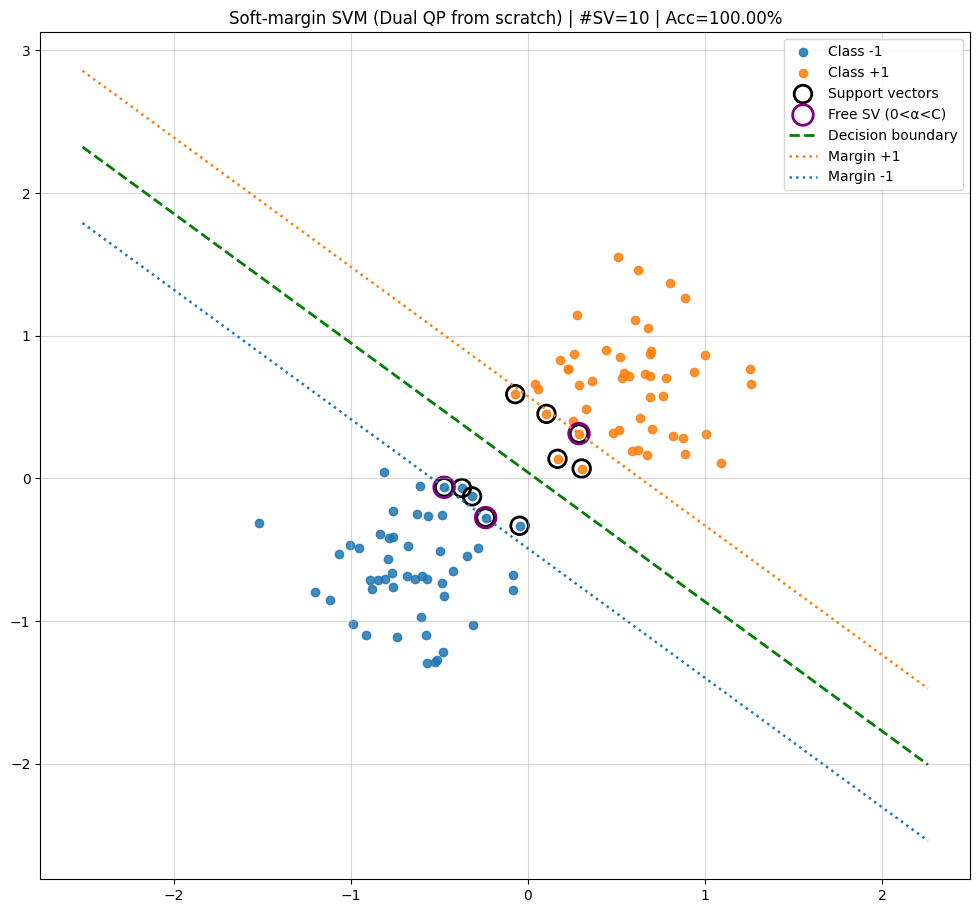

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def make_data_soft(n=120, seed=42, gap=0.25, noise=0.20):
    np.random.seed(seed)
    X_neg = np.random.randn(n, 2) * noise + np.array([-gap, -gap])
    X_pos = np.random.randn(n, 2) * noise + np.array([gap,  gap])
    X = np.vstack([X_neg, X_pos]).astype(float)
    y = np.hstack([-np.ones(n), np.ones(n)]).astype(float)
    return X, y, X_neg, X_pos


def build_Q_linear(X, y):
    K = X @ X.T
    yy = np.outer(y, y)
    Q = yy * K
    return 0.5 * (Q + Q.T)


def proj_box(a, C):
    return np.clip(a, 0.0, C)


def proj_y_eq_0(a, y):
    denom = np.dot(y, y)
    if denom < 1e-15:
        return a
    return a - y * (np.dot(y, a) / denom)


def proj_intersection_dykstra_soft(a0, y, C, iters=300, tol=1e-12):
    a = a0.copy()
    p = np.zeros_like(a)
    q = np.zeros_like(a)

    for _ in range(iters):
        a_old = a

        x = proj_box(a + p, C)
        p = a + p - x

        a = proj_y_eq_0(x + q, y)
        q = x + q - a

        if np.linalg.norm(a - a_old) < tol:
            break

    a = proj_box(a, C)
    return a


def solve_dual_qp_projected_soft(Q, y, C=1.0, lr=0.01, steps=12000, proj_iters=300, verbose=True):
    n = len(y)
    a = np.zeros(n, dtype=float)
    one = np.ones(n, dtype=float)

    def obj(a):
        return 0.5 * a @ (Q @ a) - one @ a

    for t in range(1, steps + 1):
        grad = Q @ a - one
        a = a - lr * grad

        a = proj_intersection_dykstra_soft(a, y, C, iters=proj_iters)

        if verbose and (t % 2000 == 0 or t == 1):
            print(
                f"step {t:5d} | obj={obj(a):.6f} | yTa={np.dot(y,a):.3e} | min(a)={a.min():.3e} | max(a)={a.max():.3e}")

    return a


def recover_w_b_soft(X, y, alphas, C, sv_tol=1e-6):
    w = (alphas * y) @ X

    free = np.where((alphas > sv_tol) & (alphas < C - sv_tol))[0]

    if len(free) > 0:
        b_vals = y[free] - (X[free] @ w)
        b = float(np.mean(b_vals))
        sv_idx = np.where(alphas > sv_tol)[0]
        return w, b, sv_idx, free

    sv_idx = np.where(alphas > sv_tol)[0]
    if len(sv_idx) == 0:
        raise RuntimeError(
            "No support vectors found. Try different lr/steps/C or data settings.")
    b_vals = y[sv_idx] - (X[sv_idx] @ w)
    b = float(np.mean(b_vals))
    return w, b, sv_idx, free


def check_margins(X, y, w, b):
    vals = y * (X @ w + b)
    return float(vals.min()), float(vals.max()), vals


def plot_svm_soft(X_neg, X_pos, X, y, w, b, sv_idx, free_idx, title="Soft-margin SVM (Dual QP from scratch)"):
    plt.figure(figsize=(12, 11))
    plt.scatter(X_neg[:, 0], X_neg[:, 1], alpha=0.85, label="Class -1")
    plt.scatter(X_pos[:, 0], X_pos[:, 1], alpha=0.85, label="Class +1")

    sv = X[sv_idx]
    plt.scatter(sv[:, 0], sv[:, 1], s=160, facecolors="none",
                edgecolors="k", linewidths=2.0, label="Support vectors")

    if len(free_idx) > 0:
        fv = X[free_idx]
        plt.scatter(fv[:, 0], fv[:, 1], s=220, facecolors="none",
                    edgecolors="purple", linewidths=2.0, label="Free SV (0<α<C)")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xx = np.linspace(x_min, x_max, 300)

    if abs(w[1]) < 1e-12:
        plt.axvline(-b / (w[0] + 1e-12), linestyle="--",
                    linewidth=2, color="green", label="Decision boundary")
        plt.axvline(-(b - 1) / (w[0] + 1e-12), linestyle=":",
                    linewidth=1.8, color="tab:orange", label="Margin +1")
        plt.axvline(-(b + 1) / (w[0] + 1e-12), linestyle=":",
                    linewidth=1.8, color="tab:blue", label="Margin -1")
    else:
        yy0 = -(w[0] * xx + b) / w[1]
        yy1 = -(w[0] * xx + b - 1) / w[1]
        yy2 = -(w[0] * xx + b + 1) / w[1]

        plt.plot(xx, yy0, "--", linewidth=2,
                 color="green", label="Decision boundary")
        plt.plot(xx, yy1, ":", linewidth=1.8,
                 color="tab:orange", label="Margin +1")
        plt.plot(xx, yy2, ":", linewidth=1.8,
                 color="tab:blue", label="Margin -1")

    preds = np.where((X @ w + b) >= 0, 1.0, -1.0)
    acc = (preds == y).mean() * 100.0

    plt.title(f"{title} | #SV={len(sv_idx)} | Acc={acc:.2f}%")
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    X, y, Xn, Xp = make_data_soft(n=50, seed=42, gap=0.6, noise=0.35)

    Q = build_Q_linear(X, y)

    C = 1.0
    alphas = solve_dual_qp_projected_soft(
        Q, y, C=C,
        lr=0.01,
        steps=14000,
        proj_iters=400,
        verbose=True
    )

    w, b, sv_idx, free_idx = recover_w_b_soft(X, y, alphas, C=C, sv_tol=1e-6)

    minv, maxv, vals = check_margins(X, y, w, b)
    print("\nRecovered (soft-margin):")
    print("w =", w)
    print("b =", b)
    print("min y*(w·x+b) =", minv)
    print("support vectors =", len(sv_idx), "| free SV =", len(free_idx))

    plot_svm_soft(Xn, Xp, X, y, w, b, sv_idx, free_idx)